In [ ]:
import polars as pl

train = pl.read_csv('train_part.csv')
train_add = pl.read_csv('train_part_add.csv')

test = pl.read_csv('test.csv')
test_add = pl.read_csv('test_add.csv')

member = pl.read_csv('members_nn.csv').sort('msno')
song = pl.read_csv('songs_nn.csv').sort('song_id')

member_add = pl.read_csv('members_add.csv').sort('msno')

print(train.shape)
print(train_add.shape)
print(test.shape)
print(test_add.shape)
print(member.shape)
print(song.shape)
print(member_add.shape)

(7056972, 92)
(7056972, 10)
(2556790, 92)
(2556790, 10)
(34403, 120)
(419839, 100)
(34403, 22)


In [ ]:
import time
import os
import gc
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler

# Torch GPU info
import torch
if torch.backends.mps.is_available():
    print("MPS-driver is ready")
if torch.backends.mps.is_built():
    print("PyTorch is build with MPS support")

MODEL_DIR = './models'
SUB_DIR   = './temp_nn'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUB_DIR,   exist_ok=True)

folder = 'training'

# === Загрузка данных ===
if folder == 'training':
    train = pl.read_csv('train_part.csv')
    train_add = pl.read_csv('train_part_add.csv')
elif folder == 'validation':
    train = pl.read_csv(f'./input/{folder}/train.csv')
    train_add = pl.read_csv(f'./input/{folder}/train_add.csv')

train_y = train['target'].to_numpy()
train = train.drop('target')

test = pl.read_csv('test.csv')
test_add = pl.read_csv('test_add.csv')
test_id = test['id'].to_numpy()
test = test.drop('id')

# Добавление признаков из *_add
train = train.hstack(train_add.drop_in_place('id') if 'id' in train_add.columns else train_add)
test = test.hstack(test_add.drop_in_place('id') if 'id' in test_add.columns else test_add)

print('Train data loaded.')

# === Загрузка доп. таблиц ===
member = pl.read_csv('members_nn.csv').sort('msno')
member_add = pl.read_csv('members_add.csv').sort('msno').fill_null(0)
member = member.join(member_add, on='msno', how='left')

song = pl.read_csv('songs_nn.csv').sort('song_id')

print('Member/Song data loaded.')

# === Merge member и song информации ===
member_cols = ['msno', 'city', 'gender', 'registered_via', 'registration_init_time', 'expiration_date']
song_cols = ['song_id', 'artist_name', 'composer', 'lyricist', 'language',
             'first_genre_id', 'second_genre_id', 'third_genre_id', 'cc', 'xxx']

train = train.join(member.select(member_cols), on='msno', how='left')
test = test.join(member.select(member_cols), on='msno', how='left')

train = train.join(song.select(song_cols), on='song_id', how='left')
test = test.join(song.select(song_cols), on='song_id', how='left')

# === Merge before/after song info ===
base_cols = ['song_id', 'artist_name', 'language', 'first_genre_id', 'song_rec_cnt']
tmp = song.select(base_cols)

tmp_before = tmp.rename({col: f'before_{col}' for col in tmp.columns})
tmp_after  = tmp.rename({col: f'after_{col}' for col in tmp.columns})

train = train.join(tmp_before, left_on='before_song_id', right_on='before_song_id', how='left')
test  = test.join(tmp_before, left_on='before_song_id', right_on='before_song_id', how='left')

train = train.join(tmp_after, left_on='after_song_id', right_on='after_song_id', how='left')
test  = test.join(tmp_after, left_on='after_song_id', right_on='after_song_id', how='left')

del tmp, tmp_before, tmp_after
gc.collect()

# === Создание логических признаков ===
bool_feats = [
    ("before_type_same", "source_type", "before_source_type"),
    ("after_type_same", "source_type", "after_source_type"),
    ("before_artist_same", "artist_name", "before_artist_name"),
    ("after_artist_same", "artist_name", "after_artist_name"),
    ("before_genre_same", "first_genre_id", "before_first_genre_id"),
    ("after_genre_same", "first_genre_id", "after_first_genre_id"),
]

for name, col1, col2 in bool_feats:
    train = train.with_columns(((pl.col(col1) == pl.col(col2)).cast(pl.Int8)).alias(name))
    test  = test.with_columns(((pl.col(col1) == pl.col(col2)).cast(pl.Int8)).alias(name))

print('Data preparation done.')

# === Генерация входов ===
embedding_features = ['msno', 'city', 'gender', 'registered_via',
                      'artist_name', 'language', 'cc',
                      'source_type', 'source_screen_name', 'source_system_tab',
                      'before_source_type', 'after_source_type',
                      'before_source_screen_name', 'after_source_screen_name',
                      'before_language', 'after_language',
                      'song_id', 'before_song_id', 'after_song_id']

genre_features = ['first_genre_id', 'second_genre_id']

context_features = ['after_artist_same', 'after_song_rec_cnt', 'after_timestamp',
    'after_type_same', 'before_artist_same', 'before_song_rec_cnt',
    'before_timestamp', 'before_type_same', 'msno_10000_after_cnt',
    'msno_10000_before_cnt', 'msno_10_after_cnt', 'msno_10_before_cnt',
    'msno_25_after_cnt', 'msno_25_before_cnt', 'msno_50000_after_cnt',
    'msno_50000_before_cnt', 'msno_5000_after_cnt', 'msno_5000_before_cnt',
    'msno_500_after_cnt', 'msno_500_before_cnt', 'msno_source_screen_name_prob',
    'msno_source_system_tab_prob', 'msno_source_type_prob', 'msno_till_now_cnt',
    'registration_init_time', 'song_50000_after_cnt', 'song_50000_before_cnt',
    'song_till_now_cnt', 'timestamp', 'msno_artist_name_prob', 'msno_first_genre_id_prob',
    'msno_xxx_prob', 'msno_language_prob', 'msno_yy_prob', 'msno_source_prob',
    'song_source_system_tab_prob', 'song_source_screen_name_prob', 'song_source_type_prob']

train_embeddings = [train[col].to_numpy() for col in embedding_features]
test_embeddings  = [test[col].to_numpy() for col in embedding_features]

train_genre = [train[col].to_numpy() for col in genre_features]
test_genre  = [test[col].to_numpy() for col in genre_features]

train_context = train.select(context_features).to_numpy()
test_context  = test.select(context_features).to_numpy()

# === Стандартизация контекста ===
ss_context = StandardScaler()
train_context = ss_context.fit_transform(train_context)
test_context = ss_context.transform(test_context)

del train, test
gc.collect()

Train data loaded.
Member/Song data loaded.
Data preparation done.


0

In [ ]:
from sklearn.preprocessing import StandardScaler

# === 1. User features (usr_feat) ===
usr_features = [
    'bd', 'expiration_date', 'msno_rec_cnt',
    'msno_source_screen_name_0', 'msno_source_screen_name_1', 'msno_source_screen_name_10',
    'msno_source_screen_name_11', 'msno_source_screen_name_12', 'msno_source_screen_name_13',
    'msno_source_screen_name_14', 'msno_source_screen_name_17', 'msno_source_screen_name_18',
    'msno_source_screen_name_19', 'msno_source_screen_name_2', 'msno_source_screen_name_20',
    'msno_source_screen_name_21', 'msno_source_screen_name_3', 'msno_source_screen_name_4',
    'msno_source_screen_name_5', 'msno_source_screen_name_6', 'msno_source_screen_name_7',
    'msno_source_screen_name_8', 'msno_source_screen_name_9',
    'msno_source_system_tab_0', 'msno_source_system_tab_1', 'msno_source_system_tab_2',
    'msno_source_system_tab_3', 'msno_source_system_tab_4', 'msno_source_system_tab_5',
    'msno_source_system_tab_6', 'msno_source_system_tab_7', 'msno_source_system_tab_8',
    'msno_source_type_0', 'msno_source_type_1', 'msno_source_type_10', 'msno_source_type_11',
    'msno_source_type_2', 'msno_source_type_3', 'msno_source_type_4', 'msno_source_type_5',
    'msno_source_type_6', 'msno_source_type_7', 'msno_source_type_8', 'msno_source_type_9',
    'msno_timestamp_mean', 'msno_timestamp_std', 'registration_init_time',
    'msno_song_length_mean', 'msno_artist_song_cnt_mean', 'msno_artist_rec_cnt_mean',
    'msno_song_rec_cnt_mean', 'msno_yy_mean', 'msno_song_length_std',
    'msno_artist_song_cnt_std', 'msno_artist_rec_cnt_std', 'msno_song_rec_cnt_std',
    'msno_yy_std', 'artist_msno_cnt'
]

usr_feat = member.select(usr_features).to_numpy()
usr_feat = StandardScaler().fit_transform(usr_feat)

# === 2. Song features (song_feat) ===
song_features = [
    'artist_rec_cnt', 'artist_song_cnt', 'composer_song_cnt',
    'genre_rec_cnt', 'genre_song_cnt', 'song_length',
    'song_rec_cnt', 'song_timestamp_mean', 'song_timestamp_std',
    'xxx_rec_cnt', 'xxx_song_cnt', 'yy', 'yy_song_cnt'
]

song_feat = song.select(song_features).to_numpy()
song_feat = StandardScaler().fit_transform(song_feat)

# === 3. Component embeddings ===
n_factors = 48
usr_component_features = [f'member_component_{i}' for i in range(n_factors)]
song_component_features = [f'song_component_{i}' for i in range(n_factors)]

usr_component = member.select(usr_component_features).to_numpy()
song_component = song.select(song_component_features).to_numpy()

# === 4. Artist component embeddings ===
n_artist = 16
usr_artist_features = [f'member_artist_component_{i}' for i in range(n_artist)]
song_artist_features = [f'artist_component_{i}' for i in range(n_artist)]

usr_artist_component = member.select(usr_artist_features).to_numpy()
song_artist_component = song.select(song_artist_features).to_numpy()

# === Очистка памяти ===
del member
del song
gc.collect()

0

# Тестим нейронки разные проверяем

In [ ]:
import numpy as np
import threading
import warnings

from abc import ABCMeta, abstractmethod
from keras import backend as K

class DataGenerator(object):
    def __init__(self, class_size=None):
        self.class_size = class_size

    def flow(self, x_categorical, x_numberical, y=None, batch_size=32, shuffle=True):
        return NumpyArrayIterator(
            x_categorical, x_numberical, y, self,
            batch_size=batch_size,
            shuffle=shuffle)

class Sequence(object):

    @abstractmethod
    def __getitem__(self, index):
        raise NotImplementedError

    @abstractmethod
    def __len__(self):
        raise NotImplementedError

    def on_epoch_end(self):
        pass

class Iterator(Sequence):
    def __init__(self, n, batch_size, shuffle):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_array = None
        self.index_generator = self._flow_index()

    def _set_index_array(self):
        self.index_array = np.arange(self.n)
        if self.shuffle:
            self.index_array = np.random.permutation(self.n)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError('Asked to retrieve element {idx}, '
                             'but the Sequence '
                             'has length {length}'.format(idx=idx,
                                                          length=len(self)))
        self.total_batches_seen += 1
        if self.index_array is None:
            self._set_index_array()
        index_array = self.index_array[self.batch_size * idx:
                                       self.batch_size * (idx + 1)]
        return self._get_batches_of_transformed_samples(index_array)

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size  # round up

    def on_epoch_end(self):
        self._set_index_array()

    def reset(self):
        self.batch_index = 0

    def _flow_index(self):
        self.reset()
        while 1:
            if self.batch_index == 0:
                self._set_index_array()

            current_index = (self.batch_index * self.batch_size) % self.n
            if self.n > current_index + self.batch_size:
                self.batch_index += 1
            else:
                self.batch_index = 0
            self.total_batches_seen += 1
            yield self.index_array[current_index:
                                   current_index + self.batch_size]

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

    def _get_batches_of_transformed_samples(self, index_array):
        raise NotImplementedError

class NumpyArrayIterator(Iterator):
    def __init__(self, x_cat, x_num, y, data_generator,
                 batch_size=32, shuffle=False):
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.x_cat = x_cat
        self.x_num = x_num

        self.data_generator = data_generator
        super(NumpyArrayIterator, self).__init__(len(x_cat[0]), batch_size, shuffle)

    def _get_batches_of_transformed_samples(self, index_array):
        x_batch_deep = [data[index_array] for data in self.x_cat]
        x_batch_deep += [data[index_array] for data in self.x_num]

        if self.y is None:
            return x_batch_deep
        else:
            batch_y = self.y[index_array]
            return x_batch_deep, batch_y

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)

        return self._get_batches_of_transformed_samples(index_array)

In [ ]:
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, dot, add
from keras.models import Model
from keras.initializers import RandomUniform
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.metrics import AUC  

def get_model(K, K0, lw=1e-4, lw1=1e-4, lr=1e-3, act='relu', batchnorm=False):
    embedding_inputs  = []
    embedding_outputs = []

    # ---------- 1. Категориальные признаки ----------
    for i in range(len(embedding_features) - 3):  # кроме song_id и его окрестностей
        tmp_input = Input(shape=(1,), dtype='int32', name=f'{embedding_features[i]}_input')
        max_cat = int(max(train_embeddings[i].max(), test_embeddings[i].max()) + 1)

        tmp_embeddings = Embedding(input_dim=max_cat,
                                   output_dim=K if i == 0 else K0,
                                   embeddings_initializer=RandomUniform(-0.005, 0.005),
                                   embeddings_regularizer=l2(lw),
                                   name=f'{embedding_features[i]}_embeddings')(tmp_input)
        tmp_embeddings = Flatten(name=f'{embedding_features[i]}_flatten')(tmp_embeddings)

        embedding_inputs.append(tmp_input)
        embedding_outputs.append(tmp_embeddings)

    # ---------- 2. song_id и его соседи ----------
    for i in range(-3, 0):  # последние 3 фичи
        idx = i + len(embedding_features)
        tmp_input = Input(shape=(1,), dtype='int32', name=f'{embedding_features[idx]}_input')
        max_cat = int(max(train_embeddings[idx].max(), test_embeddings[idx].max()) + 1)

        tmp_embeddings = Embedding(input_dim=max_cat,
                                   output_dim=K0,
                                   embeddings_initializer=RandomUniform(-0.005, 0.005),
                                   embeddings_regularizer=l2(lw),
                                   name=f'{embedding_features[idx]}_embeddings')(tmp_input)
        tmp_embeddings = Flatten(name=f'{embedding_features[idx]}_flatten')(tmp_embeddings)

        embedding_inputs.append(tmp_input)
        embedding_outputs.append(tmp_embeddings)

    # ---------- 3. Жанры ----------
    max_genre = int(max(np.max(train_genre), np.max(test_genre)) + 1)
    genre_embeddings = Embedding(input_dim=max_genre,
                                 output_dim=K0,
                                 embeddings_initializer=RandomUniform(-0.05, 0.05),
                                 embeddings_regularizer=l2(lw),
                                 name='genre_embeddings')

    genre_inputs, genre_outputs = [], []
    for i, g in enumerate(genre_features):
        g_in = Input(shape=(1,), dtype='int32', name=f'{g}_input')
        g_emb = Flatten()(genre_embeddings(g_in))
        genre_inputs.append(g_in)
        genre_outputs.append(g_emb)

    # ---------- 4. Предобученные признаки ----------
    usr_input = Embedding(usr_feat.shape[0], usr_feat.shape[1], weights=[usr_feat],
                          trainable=False, name='usr_feat')(embedding_inputs[0])
    usr_input = Flatten()(usr_input)

    song_input = Embedding(song_feat.shape[0], song_feat.shape[1], weights=[song_feat],
                           trainable=False, name='song_feat')(embedding_inputs[-3])
    song_input = Flatten()(song_input)

    usr_component_input = Embedding(usr_component.shape[0], usr_component.shape[1],
                                    weights=[usr_component], trainable=False,
                                    name='usr_component')(embedding_inputs[0])
    usr_component_input = Flatten()(usr_component_input)

    song_component_embeddings = Embedding(song_component.shape[0], song_component.shape[1],
                                          weights=[song_component], trainable=False,
                                          name='song_component')
    song_component_input = Flatten()(song_component_embeddings(embedding_inputs[-3]))
    before_song_component_input = Flatten()(song_component_embeddings(embedding_inputs[-2]))
    after_song_component_input  = Flatten()(song_component_embeddings(embedding_inputs[-1]))

    usr_artist_component_input = Embedding(usr_artist_component.shape[0],
                                           usr_artist_component.shape[1],
                                           weights=[usr_artist_component], trainable=False,
                                           name='usr_artist_component')(embedding_inputs[0])
    usr_artist_component_input = Flatten()(usr_artist_component_input)

    song_artist_component_embeddings = Embedding(song_artist_component.shape[0],
                                                 song_artist_component.shape[1],
                                                 weights=[song_artist_component], trainable=False,
                                                 name='song_artist_component')
    song_artist_component_input = Flatten()(song_artist_component_embeddings(embedding_inputs[-3]))
    before_song_artist_component_input = Flatten()(song_artist_component_embeddings(embedding_inputs[-2]))
    after_song_artist_component_input  = Flatten()(song_artist_component_embeddings(embedding_inputs[-1]))

    # ---------- 5. Контекст ----------
    context_input = Input(shape=(train_context.shape[1],), name='context_input')

    # ---------- 6. Профили ----------
    usr_profile = concatenate(embedding_outputs[1:4] + [usr_input, usr_component_input, usr_artist_component_input])
    song_profile = concatenate(embedding_outputs[4:7] + genre_outputs + [song_input, song_component_input, song_artist_component_input])

    # ---------- 7. Dot-продукты ----------
    multiply_component         = dot([usr_component_input, song_component_input], axes=1)
    multiply_artist_component = dot([usr_artist_component_input, song_artist_component_input], axes=1)
    multiply_before_song       = dot([before_song_component_input, song_component_input], axes=1, normalize=True)
    multiply_after_song        = dot([after_song_component_input, song_component_input], axes=1, normalize=True)
    multiply_before_artist     = dot([before_song_artist_component_input, song_artist_component_input], axes=1, normalize=True)
    multiply_after_artist      = dot([after_song_artist_component_input, song_artist_component_input], axes=1, normalize=True)

    context_profile = concatenate([
        *embedding_outputs[7:],
        context_input,
        multiply_component,
        multiply_artist_component,
        before_song_component_input,
        after_song_component_input,
        before_song_artist_component_input,
        after_song_artist_component_input,
        multiply_before_song,
        multiply_after_song,
        multiply_before_artist,
        multiply_after_artist
    ])

    # ---------- 8. Обработка профилей ----------
    def dense_block(x, name):
        x = Dense(K * 2, kernel_regularizer=l1(lw1), name=f'{name}_dense')(x)
        if batchnorm:
            x = BatchNormalization(name=f'{name}_bn')(x)
        x = Activation(act, name=f'{name}_act')(x)
        return x

    usr_embeddings = dense_block(usr_profile, 'usr_profile')
    usr_embeddings = Dense(K, name='usr_output')(usr_embeddings)
    usr_embeddings = add([usr_embeddings, embedding_outputs[0]])

    song_embeddings = dense_block(song_profile, 'song_profile')
    song_embeddings = Dense(K, name='song_output')(song_embeddings)

    context_embeddings = dense_block(context_profile, 'context_profile')

    # ---------- 9. Совместное пространство ----------
    joint = dot([usr_embeddings, song_embeddings], axes=1)
    joint_embeddings = concatenate([usr_embeddings, song_embeddings, context_embeddings, joint])

    # ---------- 10. Предсказание ----------
    x = dense_block(joint_embeddings, 'pred_0')
    x = dense_block(concatenate([joint_embeddings, x]), 'pred_1')
    x = dense_block(concatenate([joint_embeddings, x]), 'pred_2')

    x = concatenate([joint_embeddings, x])
    x = Dropout(0.5)(x)
    preds = Dense(1, activation='sigmoid', name='prediction')(x)

    # ---------- 11. Финальная модель ----------
    model = Model(inputs=embedding_inputs + genre_inputs + [context_input], outputs=preds)
    # model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    return model

In [ ]:
from sklearn.model_selection import train_test_split

# Получаем индексы для train/val
idx_train, idx_val = train_test_split(np.arange(len(train_y)), test_size=0.1, random_state=42)

# Делаем X_train/X_val как списки массивов, порезанных по индексам
X_train = [x[idx_train] for x in (train_embeddings + train_genre)] + [train_context[idx_train]]
X_val   = [x[idx_val] for x in (train_embeddings + train_genre)] + [train_context[idx_val]]

y_train_split = train_y[idx_train]
y_val = train_y[idx_val]

In [ ]:
# === 2. Построение модели с лучшими гиперпараметрами ===
model = get_model(
    K=74,
    K0=11,
    lw=5.315258e-4,
    lw1=0.0,
    lr=0.001405365,
    act='elu',
    batchnorm=False
)

# === 3. Callbacks ===

# Learning rate schedule
def schedule_fn(epoch):
    return 0.001405365 * (0.778385 ** epoch)
lr_cb = LearningRateScheduler(schedule_fn)

# Время эпох
class EpochTimer(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.t0 = time.time()
        print(f"\n🕒 Starting epoch {epoch+1}")
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self.t0
        print(f"✅ Epoch {epoch+1} done in {dt:.1f}s — loss = {logs['loss']:.5f}, val_loss = {logs['val_loss']:.5f}")

# Early stopping + LR scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
# === 4. Обучение модели ===
history = model.fit(
    x=X_train,
    y=y_train_split,
    validation_data=(X_val, y_val),
    batch_size=8192,
    epochs=40,
    callbacks=[lr_cb, EpochTimer(), early_stop, reduce_lr],
    verbose=0
)


🕒 Starting epoch 1
✅ Epoch 1 done in 30.4s — loss = 0.58287, val_loss = 0.56680

🕒 Starting epoch 2
✅ Epoch 2 done in 6.1s — loss = 0.55663, val_loss = 0.55045

🕒 Starting epoch 3
✅ Epoch 3 done in 6.0s — loss = 0.54087, val_loss = 0.53834

🕒 Starting epoch 4
✅ Epoch 4 done in 6.0s — loss = 0.53143, val_loss = 0.53163

🕒 Starting epoch 5
✅ Epoch 5 done in 6.0s — loss = 0.52424, val_loss = 0.52591

🕒 Starting epoch 6
✅ Epoch 6 done in 6.0s — loss = 0.51873, val_loss = 0.51839

🕒 Starting epoch 7
✅ Epoch 7 done in 5.9s — loss = 0.51371, val_loss = 0.51379

🕒 Starting epoch 8
✅ Epoch 8 done in 6.0s — loss = 0.50945, val_loss = 0.51138

🕒 Starting epoch 9
✅ Epoch 9 done in 6.0s — loss = 0.50571, val_loss = 0.50861

🕒 Starting epoch 10
✅ Epoch 10 done in 6.0s — loss = 0.50224, val_loss = 0.50678

🕒 Starting epoch 11
✅ Epoch 11 done in 6.0s — loss = 0.49896, val_loss = 0.50386

🕒 Starting epoch 12
✅ Epoch 12 done in 6.0s — loss = 0.49554, val_loss = 0.50396

🕒 Starting epoch 13
✅ Epoch 13 d

In [ ]:
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import roc_auc_score

# === 1. Готовим тестовые входы ===
X_test = test_embeddings + test_genre + [test_context]

# === 2. Предсказание ===
print("📊 Predicting on test set...")
t1 = time.time()

test_pred = model.predict(
    x=X_test,
    batch_size=16384,
    verbose=1
)

print(f"✅ Test prediction done in {time.time() - t1:.1f}s")

# === 3. AUC на валидации (уже предсказано заранее) ===
val_pred = model.predict(X_val, batch_size=16384)
val_auc = roc_auc_score(y_val, val_pred)
print(f"🎯 Final validation AUC: {val_auc:.5f}")

# === 4. Сохраняем модель ===
final_loss = history.history['loss'][-1]
model_path = os.path.join(MODEL_DIR, f"nn_final_auc{val_auc:.5f}.keras")
model.save(model_path)
print(f"✔ Model saved to: {model_path}")

# === 5. Сохраняем сабмишен ===
submission = pd.DataFrame({
    'id': test_id,
    'target': test_pred.ravel()
})

sub_path = os.path.join(
    SUB_DIR,
    f"nn_{val_auc:.5f}_{final_loss:.5f}_{np.random.randint(1e5)}.csv"
)
submission.to_csv(sub_path, index=False)
print(f"📁 Submission saved to: {sub_path}")

📊 Predicting on test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
✅ Test prediction done in 5.3s
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
🎯 Final validation AUC: 0.83986
✔ Model saved to: ./models/nn_final_auc0.83986.keras
📁 Submission saved to: ./temp_nn/nn_0.83986_0.47935_64999.csv


In [ ]:
model.save("./temp_nn/model1.keras")

In [ ]:
# смотрим все метрики и сохраняем их
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
import pandas as pd
import os

# Предсказания
val_pred = model.predict(X_val, batch_size=16384).ravel()
val_class = (val_pred >= 0.5).astype(int)

# Метрики
val_auc = roc_auc_score(y_val, val_pred)
acc = accuracy_score(y_val, val_class)
prec = precision_score(y_val, val_class)
rec = recall_score(y_val, val_class)
f1 = f1_score(y_val, val_class)
tn, fp, fn, tp = confusion_matrix(y_val, val_class).ravel()

# Вывод
print(f"🎯 Final validation AUC:  {val_auc:.5f}")
print(f"✔ Accuracy              : {acc:.5f}")
print(f"✔ Precision             : {prec:.5f}")
print(f"✔ Recall                : {rec:.5f}")
print(f"✔ F1 Score              : {f1:.5f}")
print(f"✔ Confusion matrix      : TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# Сохраняем в CSV
metrics_df = pd.DataFrame([{
    'val_auc': val_auc,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'tp': tp,
    'fp': fp,
    'tn': tn,
    'fn': fn
}])

# Путь для сохранения
metrics_path = os.path.join(SUB_DIR, "validation_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"📁 Metrics saved to: {metrics_path}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
🎯 Final validation AUC:  0.83986
✔ Accuracy              : 0.75793
✔ Precision             : 0.76572
✔ Recall                : 0.75143
✔ F1 Score              : 0.75851
✔ Confusion matrix      : TP=268277, FP=82083, TN=266595, FN=88743
📁 Metrics saved to: ./temp_nn/validation_metrics.csv


# 2 модель

In [ ]:
import numpy as np
import threading
import warnings

from abc import ABCMeta, abstractmethod
from keras import backend as K

class DataGenerator(object):
    def __init__(self, class_size=None):
        self.class_size = class_size

    def flow(self, x_categorical, x_numberical, y=None, batch_size=32, shuffle=True):
        return NumpyArrayIterator(
            x_categorical, x_numberical, y, self,
            batch_size=batch_size,
            shuffle=shuffle)

class Sequence(object):

    @abstractmethod
    def __getitem__(self, index):
        raise NotImplementedError

    @abstractmethod
    def __len__(self):
        raise NotImplementedError

    def on_epoch_end(self):
        pass

class Iterator(Sequence):
    def __init__(self, n, batch_size, shuffle):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_array = None
        self.index_generator = self._flow_index()

    def _set_index_array(self):
        self.index_array = np.arange(self.n)
        if self.shuffle:
            self.index_array = np.random.permutation(self.n)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError('Asked to retrieve element {idx}, '
                             'but the Sequence '
                             'has length {length}'.format(idx=idx,
                                                          length=len(self)))
        self.total_batches_seen += 1
        if self.index_array is None:
            self._set_index_array()
        index_array = self.index_array[self.batch_size * idx:
                                       self.batch_size * (idx + 1)]
        return self._get_batches_of_transformed_samples(index_array)

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size  # round up

    def on_epoch_end(self):
        self._set_index_array()

    def reset(self):
        self.batch_index = 0

    def _flow_index(self):
        self.reset()
        while 1:
            if self.batch_index == 0:
                self._set_index_array()

            current_index = (self.batch_index * self.batch_size) % self.n
            if self.n > current_index + self.batch_size:
                self.batch_index += 1
            else:
                self.batch_index = 0
            self.total_batches_seen += 1
            yield self.index_array[current_index:
                                   current_index + self.batch_size]

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

    def _get_batches_of_transformed_samples(self, index_array):
        raise NotImplementedError

class NumpyArrayIterator(Iterator):
    def __init__(self, x_cat, x_num, y, data_generator,
                 batch_size=32, shuffle=False):
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.x_cat = x_cat
        self.x_num = x_num

        self.data_generator = data_generator
        super(NumpyArrayIterator, self).__init__(len(x_cat[0]), batch_size, shuffle)

    def _get_batches_of_transformed_samples(self, index_array):
        x_batch_deep = [data[index_array] for data in self.x_cat]
        x_batch_deep += [data[index_array] for data in self.x_num]

        if self.y is None:
            return x_batch_deep
        else:
            batch_y = self.y[index_array]
            return x_batch_deep, batch_y

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)

        return self._get_batches_of_transformed_samples(index_array)

In [ ]:
dataGenerator = DataGenerator()

train_flow = dataGenerator.flow(train_embeddings+train_genre, [train_context], \
        train_y, batch_size=8192, shuffle=True)

######################################################
## Model Structure
######################################################

## define the model
def FunctionalDense(n, x, batchnorm=False, act='relu', lw1=0.0, dropout=0.0, name=''):
    if lw1 == 0.0:
        x = Dense(n, name=name+'_dense')(x)
    else:
        x = Dense(n, kernel_regularizer=l1(lw1), name=name+'_dense')(x)

    if batchnorm:
        x = BatchNormalization(name=name+'_batchnorm')(x)

    if act in {'relu', 'tanh', 'sigmoid'}:
        x = Activation(act, name=name+'_activation')(x)
    elif act =='prelu':
        x = PReLU(name=name+'_activation')(x)
    elif act == 'leakyrelu':
        x = LeakyReLU(name=name+'_activation')(x)
    elif act == 'elu':
        x = ELU(name=name+'_activation')(x)

    if dropout and dropout > 0:
        x = Dropout(dropout, name=name+'_dropout')(x)

    return x

def get_model(K, K0, lw=1e-4, lw1=1e-4, lr=1e-3, act='relu', batchnorm=False):
    embedding_inputs  = []
    embedding_outputs = []

    # ---------- 1. «обычные» категориальные признаки ----------
    for i in range(len(embedding_features) - 3):
        val_bound = 0.0 if i == 0 else 0.005
        tmp_input = Input(shape=(1,), dtype='int32',
                          name=f'{embedding_features[i]}_input')

        # ⇩⇩⇩ главное исправление: берём максимум по train *и* test ⇩⇩⇩
        max_cat = int(
            max(
                train_embeddings[i].max(),
                test_embeddings[i].max()
            ) + 1
        )
        tmp_embeddings = Embedding(
            input_dim=max_cat,
            output_dim=K if i == 0 else K0,
            embeddings_initializer=RandomUniform(minval=-val_bound, maxval=val_bound),
            embeddings_regularizer=l2(lw),
            trainable=True,
            name=f'{embedding_features[i]}_embeddings'
        )(tmp_input)
        tmp_embeddings = Flatten(name=f'{embedding_features[i]}_flatten')(tmp_embeddings)

        embedding_inputs.append(tmp_input)
        embedding_outputs.append(tmp_embeddings)

    # ---------- 2. song_id / before_song_id / after_song_id ----------
    # здесь то же самое — берём общий максимум
    max_song_id = int(max(
        train_embeddings[-3].max(), test_embeddings[-3].max()) + 1)

    song_id_input        = Input(shape=(1,), dtype='int32', name='song_id_input')
    before_song_id_input = Input(shape=(1,), dtype='int32', name='before_song_id_input')
    after_song_id_input  = Input(shape=(1,), dtype='int32', name='after_song_id_input')

    embedding_inputs += [song_id_input, before_song_id_input, after_song_id_input]

    # ---------- 3. жанровые признаки ----------
    max_genre = int(max(np.max(train_genre), np.max(test_genre)) + 1)
    genre_embeddings = Embedding(
        input_dim=max_genre,
        output_dim=K0,
        embeddings_initializer=RandomUniform(minval=-0.05, maxval=0.05),
        embeddings_regularizer=l2(lw),
        trainable=True,
        name='genre_embeddings'
    )
    genre_inputs, genre_outputs = [], []
    for i, g in enumerate(genre_features):
        g_in  = Input(shape=(1,), dtype='int32', name=f'{g}_input')
        g_emb = Flatten(name=f'{g}_flatten')(genre_embeddings(g_in))
        genre_inputs.append(g_in)
        genre_outputs.append(g_emb)

    usr_input = Embedding(usr_feat.shape[0],
            usr_feat.shape[1],
            weights=[usr_feat],
            trainable=False,
            name='usr_feat')(embedding_inputs[0])
    usr_input = Flatten(name='usr_feat_flatten')(usr_input)

    song_input = Embedding(song_feat.shape[0],
            song_feat.shape[1],
            weights=[song_feat],
            trainable=False,
            name='song_feat')(song_id_input)
    song_input = Flatten(name='song_feat_flatten')(song_input)

    usr_component_input = Embedding(usr_component.shape[0],
            usr_component.shape[1],
            weights=[usr_component],
            trainable=False,
            name='usr_component')(embedding_inputs[0])
    usr_component_input = Flatten(name='usr_component_flatten')(usr_component_input)

    song_component_embeddings = Embedding(song_component.shape[0],
            song_component.shape[1],
            weights=[song_component],
            trainable=False,
            name='song_component')
    song_component_input = song_component_embeddings(song_id_input)
    song_component_input = Flatten(name='song_component_flatten')(song_component_input)
    before_song_component_input = song_component_embeddings(before_song_id_input)
    before_song_component_input = Flatten(name='before_song_component_flatten')(before_song_component_input)
    after_song_component_input = song_component_embeddings(after_song_id_input)
    after_song_component_input = Flatten(name='after_song_component_flatten')(after_song_component_input)

    usr_artist_component_input = Embedding(usr_artist_component.shape[0],
            usr_artist_component.shape[1],
            weights=[usr_artist_component],
            trainable=False,
            name='usr_artist_component')(embedding_inputs[0])
    usr_artist_component_input = Flatten(name='usr_artist_component_flatten')(usr_artist_component_input)

    song_artist_component_embeddings = Embedding(song_artist_component.shape[0],
            song_artist_component.shape[1],
            weights=[song_artist_component],
            trainable=False,
            name='song_artist_component')
    song_artist_component_input = song_artist_component_embeddings(song_id_input)
    song_artist_component_input = Flatten(name='song_artist_component_flatten')(song_artist_component_input)
    before_song_artist_component_input = song_artist_component_embeddings(before_song_id_input)
    before_song_artist_component_input = Flatten(name='before_song_artist_component_flatten')(before_song_artist_component_input)
    after_song_artist_component_input = song_artist_component_embeddings(after_song_id_input)
    after_song_artist_component_input = Flatten(name='after_song_artist_component_flatten')(after_song_artist_component_input)

    context_input = Input(shape=(len(context_features),), name='context_feat')

    # basic profiles
    usr_profile = concatenate(embedding_outputs[1:4]+[usr_input, \
            usr_component_input, usr_artist_component_input], name='usr_profile')
    song_profile = concatenate(embedding_outputs[4:7]+genre_outputs+[song_input, \
            song_component_input, song_artist_component_input], name='song_profile')

    multiply_component = dot([usr_component_input, song_component_input], axes=1, name='component_dot')
    multiply_artist_component = dot([usr_artist_component_input, \
            song_artist_component_input], axes=1, name='artist_component_dot')
    multiply_before_song = dot([before_song_component_input, song_component_input], \
            normalize=True, axes=1, name='before_component_dot')
    multiply_after_song = dot([after_song_component_input, song_component_input], \
            normalize=True, axes=1, name='after_component_dot')
    multiply_before_artist = dot([before_song_artist_component_input, song_artist_component_input], \
            normalize=True, axes=1, name='before_artist_component_dot')
    multiply_after_artist = dot([after_song_artist_component_input, song_artist_component_input], \
            normalize=True, axes=1, name='after_artist_component_dot')
    context_profile = concatenate(embedding_outputs[7:]+[context_input, \
            multiply_component, multiply_artist_component, before_song_component_input, \
            after_song_component_input, before_song_artist_component_input, \
            after_song_artist_component_input, multiply_before_song, multiply_after_song, \
            multiply_before_artist, multiply_after_artist], name='context_profile')

    # user field
    usr_embeddings = FunctionalDense(K*2, usr_profile, lw1=lw1, batchnorm=batchnorm, act=act, name='usr_profile')
    usr_embeddings = Dense(K, name='usr_profile_output')(usr_embeddings)
    usr_embeddings = add([usr_embeddings, embedding_outputs[0]], name='usr_embeddings')

    # song field
    song_embeddings = FunctionalDense(K*2, song_profile, lw1=lw1, batchnorm=batchnorm, act=act, name='song_profile')
    song_embeddings = Dense(K, name='song_profile_output')(song_embeddings)
    #song_embeddings = add([song_embeddings, embedding_outputs[4]], name='song_embeddings')

    # context field
    context_embeddings = FunctionalDense(K, context_profile, lw1=lw1, batchnorm=batchnorm, act=act, name='context_profile')

    # joint embeddings
    joint = dot([usr_embeddings, song_embeddings], axes=1, normalize=False, name='pred_cross')
    joint_embeddings = concatenate([usr_embeddings, song_embeddings, context_embeddings, joint], name='joint_embeddings')

    # top model
    preds0 = FunctionalDense(K*2, joint_embeddings, batchnorm=batchnorm, act=act, name='preds_0')
    preds1 = FunctionalDense(K*2, concatenate([joint_embeddings, preds0]), batchnorm=batchnorm, act=act, name='preds_1')
    preds2 = FunctionalDense(K*2, concatenate([joint_embeddings, preds0, preds1]), batchnorm=batchnorm, act=act, name='preds_2')

    preds = concatenate([joint_embeddings, preds0, preds1, preds2], name='prediction_aggr')
    preds = Dropout(0.5, name='prediction_dropout')(preds)
    preds = Dense(1, activation='sigmoid', name='prediction')(preds)

    model = Model(inputs=embedding_inputs+genre_inputs+[context_input], outputs=preds)

    opt = RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    return model

In [ ]:
X_train = train_embeddings + train_genre + [train_context]
y_train = train_y

X_test  = test_embeddings  + test_genre  + [test_context]
test_ids = test_id

In [ ]:
K          = 74
K0         = 11
lw         = 0.0005315258
lw1        = 0.0
lr         = 0.001405365
lr_decay   = 0.778385
activation = 'elu'
batchnorm  = False
bst_epoch  = 26
train_loss0= None  
val_auc0   = None  

# Логируем конфигурацию
print('\n' + '='*80)
print(f"Single Experiment with manual parameters")
print(f" Params: K={K}, K0={K0}, lw={lw:.2e}, lw1={lw1:.2e}")
print(f"         lr={lr:.2e}, decay={lr_decay:.4f}, act={activation}, bn={batchnorm}")
print(f" Planned epochs: {bst_epoch}")
print('='*80 + '\n')

# Построение модели
model = get_model(K, K0, lw, lw1, lr, activation, batchnorm)


Single Experiment with manual parameters
 Params: K=74, K0=11, lw=5.32e-04, lw1=0.00e+00
         lr=1.41e-03, decay=0.7784, act=elu, bn=False
 Planned epochs: 26



In [ ]:
# LR scheduler
def schedule_fn(epoch):
    new_lr = lr * (lr_decay ** epoch)
    print(f"  -> Epoch {epoch+1}: set lr = {new_lr:.6f}")
    return new_lr
lr_cb = LearningRateScheduler(schedule_fn)

# Таймер
class EpochTimer(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.t0 = time.time()
        print(f"\n  Starting epoch {epoch+1}/{bst_epoch}")
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time() - self.t0
        print(f"    Finished epoch {epoch+1} in {dt:.1f}s — loss = {logs['loss']:.5f}")

timer_cb = EpochTimer()

# Обучение
t0 = time.time()
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8192,
    epochs=bst_epoch,
    verbose=0,
    callbacks=[lr_cb, timer_cb]
)
t_total = time.time() - t0

  -> Epoch 1: set lr = 0.001405

  Starting epoch 1/26
    Finished epoch 1 in 18.7s — loss = 0.59219
  -> Epoch 2: set lr = 0.001094

  Starting epoch 2/26
    Finished epoch 2 in 5.4s — loss = 0.57001
  -> Epoch 3: set lr = 0.000851

  Starting epoch 3/26
    Finished epoch 3 in 5.4s — loss = 0.56360
  -> Epoch 4: set lr = 0.000663

  Starting epoch 4/26
    Finished epoch 4 in 5.4s — loss = 0.55940
  -> Epoch 5: set lr = 0.000516

  Starting epoch 5/26
    Finished epoch 5 in 5.4s — loss = 0.55612
  -> Epoch 6: set lr = 0.000402

  Starting epoch 6/26
    Finished epoch 6 in 5.4s — loss = 0.55332
  -> Epoch 7: set lr = 0.000313

  Starting epoch 7/26
    Finished epoch 7 in 5.4s — loss = 0.55056
  -> Epoch 8: set lr = 0.000243

  Starting epoch 8/26
    Finished epoch 8 in 5.4s — loss = 0.54702
  -> Epoch 9: set lr = 0.000189

  Starting epoch 9/26
    Finished epoch 9 in 5.4s — loss = 0.54187
  -> Epoch 10: set lr = 0.000147

  Starting epoch 10/26
    Finished epoch 10 in 5.4s — l

In [ ]:
model.save("./temp_nn/model2.keras")

In [ ]:
# 1) Итоги обучения
final_loss = history.history['loss'][-1]
print(f"\n>>> Experiment done in {t_total:.1f}s; final loss = {final_loss:.5f}")
if train_loss0 is not None:
    print(f"    baseline loss0: {train_loss0:.5f}")
    if final_loss > train_loss0 * 1.1:
        print("    ⚠️ Loss grew >10% от baseline — проверьте lr/архитектуру.")
if val_auc0 is not None:
    print(f"    Validation AUC (record): {val_auc0:.5f}")

# 2) Предсказания на валидации
val_pred = model.predict(X_val, batch_size=16384).ravel()
val_class = (val_pred >= 0.5).astype(int)

# 3) Метрики
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

val_auc = roc_auc_score(y_val, val_pred)
acc     = accuracy_score(y_val, val_class)
prec    = precision_score(y_val, val_class)
rec     = recall_score(y_val, val_class)
f1      = f1_score(y_val, val_class)
tn, fp, fn, tp = confusion_matrix(y_val, val_class).ravel()

# 4) Лог метрик
print(f"🎯 Final validation AUC:  {val_auc:.5f}")
print(f"✔ Accuracy              : {acc:.5f}")
print(f"✔ Precision             : {prec:.5f}")
print(f"✔ Recall                : {rec:.5f}")
print(f"✔ F1 Score              : {f1:.5f}")
print(f"✔ Confusion matrix      : TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# 5) Сохраняем метрики в CSV
import pandas as pd
metrics_df = pd.DataFrame([{
    'final_loss': final_loss,
    'val_auc': val_auc,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'tp': tp,
    'fp': fp,
    'tn': tn,
    'fn': fn
}])

metrics_path = os.path.join(SUB_DIR, "validation_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"📁 Metrics saved to: {metrics_path}")

# 6) Сохраняем модель
mpath = os.path.join(MODEL_DIR, f"nn_manual_{final_loss:.5f}.keras")
model.save(mpath)
print(f"  ✔ Model saved to {mpath}\n")

# 7) Предсказание на тесте
print("  Predicting on test set…")
t1 = time.time()
test_pred = model.predict(
    x=X_test,
    batch_size=16384,
    verbose=1
)
print(f"  -> Test prediction done in {time.time()-t1:.1f}s\n")

# 8) Сохраняем сабмишен
fname = os.path.join(
    SUB_DIR,
    f"nn_{val_auc:.5f}_{final_loss:.5f}_{np.random.randint(1e5)}.csv"
)
pd.DataFrame({'id': test_ids, 'target': test_pred.ravel()}).to_csv(fname, index=False)
print(f"📤 Submission saved to `{fname}`")


>>> Experiment done in 158.1s; final loss = 0.51837
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
🎯 Final validation AUC:  0.82517
✔ Accuracy              : 0.74501
✔ Precision             : 0.75846
✔ Recall                : 0.72773
✔ F1 Score              : 0.74277
✔ Confusion matrix      : TP=259813, FP=82742, TN=265936, FN=97207
📁 Metrics saved to: ./temp_nn/validation_metrics.csv
  ✔ Model saved to ./models/nn_manual_0.51837.keras

  Predicting on test set…
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
  -> Test prediction done in 3.1s

📤 Submission saved to `./temp_nn/nn_0.82517_0.51837_44214.csv`


# Третья нейросеть

In [ ]:
import os
import time
import gc
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

#####################################################
## Settings & Paths
#####################################################
folder     = 'training'
INPUT_DIR  = f'/content/drive/MyDrive/Diplom'
SUBMIT_DIR = './submission'
MODEL_DIR  = './models'
os.makedirs(SUBMIT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

#####################################################
## 1) Read feature-importance to drop low-impact cols
#####################################################
feat_imp = pd.read_csv('./lgb_feature_importance.csv')
drop_cols = feat_imp.loc[feat_imp.importance < 85, 'name'].tolist()

#####################################################
## 2) Load train/test & “add” tables
#####################################################
print('[1] Loading base & add data…')
if folder == 'training':
    train     = pd.read_csv(f'{INPUT_DIR}/train_part.csv')
    train_add = pd.read_csv(f'{INPUT_DIR}/train_part_add.csv')
else:
    train     = pd.read_csv(f'{INPUT_DIR}/train.csv')
    train_add = pd.read_csv(f'{INPUT_DIR}/train_add.csv')

test     = pd.read_csv(f'{INPUT_DIR}/test.csv')
test_add = pd.read_csv(f'{INPUT_DIR}/test_add.csv')

print(f'    train:     {train.shape}')
print(f'    train_add: {train_add.shape}')
print(f'    test:      {test.shape}')
print(f'    test_add:  {test_add.shape}')

train_y = train.pop('target')
test_id = test.pop('id')

#####################################################
## 3) Inject “add” features
#####################################################
print('[2] Injecting add-features…')
cols_add = [
    'msno_artist_name_prob','msno_first_genre_id_prob','msno_xxx_prob',
    'msno_language_prob','msno_yy_prob','source','msno_source_prob',
    'song_source_system_tab_prob','song_source_screen_name_prob',
    'song_source_type_prob'
]
train_add['source'] = train_add['source'].astype('category')
test_add ['source'] = test_add['source'].astype('category')
for c in cols_add:
    train[c] = train_add[c].values
    test [c] = test_add [c].values

del train_add, test_add; gc.collect()
print(f'    after inject: train has {train.shape[1]} cols')

#####################################################
## 4) Merge member & member_add
#####################################################
print('[3] Merging member & member_add…')
member     = pd.read_csv(f'{INPUT_DIR}/members_gbdt.csv')
member_add = pd.read_csv(f'{INPUT_DIR}/members_add.csv')

train = train.merge(member,     on='msno', how='left')
test  = test .merge(member,     on='msno', how='left')
del member; gc.collect()

train = train.merge(
    member_add[['msno','msno_song_length_mean','artist_msno_cnt']],
    on='msno', how='left')
test  = test .merge(
    member_add[['msno','msno_song_length_mean','artist_msno_cnt']],
    on='msno', how='left')
del member_add; gc.collect()

[1] Loading base & add data…
    train:     (7056972, 92)
    train_add: (7056972, 10)
    test:      (2556790, 92)
    test_add:  (2556790, 10)
[2] Injecting add-features…
    after inject: train has 101 cols
[3] Merging member & member_add…


0

In [ ]:
#####################################################
## 5) Merge songs_gbdt.csv with only needed cols
#####################################################
print('[4] Merging songs_gbdt features…')
songs_header = pd.read_csv(f'{INPUT_DIR}/songs_gbdt.csv', nrows=0).columns.tolist()
keep_songs   = [c for c in songs_header if c not in drop_cols]
usecols_songs= ['song_id'] + [c for c in keep_songs if c!='song_id']

songs = pd.read_csv(f'{INPUT_DIR}/songs_gbdt.csv', usecols=usecols_songs)
for c in songs.select_dtypes('float64'): songs[c] = songs[c].astype('float32')
for c in songs.select_dtypes('int64'):   songs[c] = songs[c].astype('int32')

train = train.merge(songs, on='song_id', how='left')
test  = test .merge(songs, on='song_id', how='left')
cols_song = songs.columns.tolist()

songs.columns = [f'before_{c}' for c in cols_song]
train = train.merge(songs, on='before_song_id', how='left')
test  = test .merge(songs, on='before_song_id', how='left')

songs.columns = [f'after_{c}' for c in cols_song]
train = train.merge(songs, on='after_song_id', how='left')
test  = test .merge(songs, on='after_song_id', how='left')

del songs; gc.collect()

#####################################################
## 6) Compute contextual & temporal features
#####################################################
print('[5] Computing extra features…')
for df in (train, test):
    df['before_type_same']   = (df['before_source_type']==df['source_type']).astype('float32')
    df['after_type_same']    = (df['after_source_type']==df['source_type']).astype('float32')
    df['before_artist_same'] = (df['before_artist_name']==df['artist_name']).astype('float32')
    df['after_artist_same']  = (df['after_artist_name']==df['artist_name']).astype('float32')
    df['time_spent']         = (df['timestamp']-df['registration_init_time']).astype('int32')
    df['time_left']          = (df['expiration_date']-df['timestamp']).astype('int32')
    df['duration']           = (df['expiration_date']-df['registration_init_time']).astype('int32')

#####################################################
## 7) Drop low-importance features & free memory
#####################################################
print('[6] Dropping low-importance features…')
train.drop(columns=drop_cols, inplace=True, errors='ignore')
test .drop(columns=drop_cols, inplace=True, errors='ignore')
gc.collect()

[4] Merging songs_gbdt features…
[5] Computing extra features…
[6] Dropping low-importance features…


0

In [ ]:
# ==================================================
# 8) Inference с готовой моделью + сабмишен
# ==================================================
import json
from sklearn.model_selection import train_test_split

MODEL_FILE = 'lgb_model.txt'          # путь к сохранённой модели
SUB_DIR    = './submission'
os.makedirs(SUB_DIR, exist_ok=True)

print('[8] Loading trained LightGBM model …')
model = lgb.Booster(model_file=MODEL_FILE)
model_feats = model.feature_name()             # список фичей, который видела модель

# ----------  функция выравнивания ----------
def align_features(df: pd.DataFrame, feats: list[str]) -> pd.DataFrame:
    """
    Делает копию df с точным набором/порядком feats.
    Недостающие колонки ищет с суффиксами _x/_y или создаёт нулями.
    Лишние выкидывает.
    """
    df = df.copy()

    for f in feats:
        if f not in df.columns:
            # пробуем найти альтернативы c _x/_y
            for suf in ['_x', '_y']:
                alt = f + suf
                if alt in df.columns:
                    df[f] = df[alt]
                    break
            else:
                df[f] = 0.0          # заполняем нулями, если совсем нет

    df = df[feats]                  # порядок и удаление лишних
    return df
# -------------------------------------------

print('[9] Aligning train / test features …')
train_aligned = align_features(train, model_feats)
test_aligned  = align_features(test,  model_feats)

# ----------  (опционально) валидируем ----------
X_tr, X_val, y_tr, y_val = train_test_split(
        train_aligned, train_y,
        test_size=0.20,
        stratify=train_y,
        random_state=42)

val_pred = model.predict(X_val, num_iteration=model.best_iteration)
val_auc  = roc_auc_score(y_val, val_pred)
print(f'🎯 Validation AUC @20% hold-out: {val_auc:.5f}')
# -----------------------------------------------

print('[10] Predicting on full test …')
test_pred = model.predict(test_aligned, num_iteration=model.best_iteration)

# ----------  сохраняем сабмишен ----------
sub = pd.DataFrame({
    'id': test_id,
    'target': test_pred.ravel()
})

fname = f"lgb_{val_auc:.5f}_{np.random.randint(100000)}.csv"
sub_path = os.path.join(SUB_DIR, fname)
sub.to_csv(sub_path, index=False)
print(f'✅ Submission saved to: {sub_path}')

[8] Loading trained LightGBM model …
[9] Aligning train / test features …
🎯 Validation AUC @20% hold-out: 0.82806
[10] Predicting on full test …
✅ Submission saved to: ./submission/lgb_0.82806_86150.csv


# Ансамбль нейросетей

In [ ]:
# ==============================================================
# STACKING: model1.keras + model2.keras + lgb_model.txt
#            → LogisticRegression meta
# ==============================================================

# ---------- 1) PATЧ: убираем JAX и гарантируем Keras 3 ---------
import subprocess, sys, os, importlib

subprocess.run(['pip', 'uninstall', '-y', 'jax', 'jaxlib'], check=False)   # убираем JAX
os.environ['KERAS_BACKEND'] = 'tensorflow'                                 # Keras → TF-backend

try:
    import keras
except ModuleNotFoundError:
    print('[setup] Keras not found — installing …')
    subprocess.run(['pip', 'install', '-q', 'keras==3.3.2', '--no-deps'], check=True)
    keras = importlib.import_module('keras')
# ----------------------------------------------------------------

import gc, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import lightgbm as lgb

MODEL_DIR  = '.'                    # файлы лежат в корне Colab
SUBMIT_DIR = Path('./submission'); SUBMIT_DIR.mkdir(exist_ok=True)

# ---------- 2) LightGBM ----------------------------------------------------
print('[Stack-LGB] Loading LightGBM model …')
lgb_model = lgb.Booster(model_file=str(Path(MODEL_DIR) / 'lgb_model.txt'))
lgb_feats = lgb_model.feature_name()

def align_features(df: pd.DataFrame, feats: list[str]) -> pd.DataFrame:
    df = df.copy()
    for f in feats:
        if f not in df.columns:
            for suf in ['_x', '_y']:
                alt = f + suf
                if alt in df.columns:
                    df[f] = df[alt]; break
            else:
                df[f] = 0.0
    return df[feats]

train_aligned = align_features(train, lgb_feats)
test_aligned  = align_features(test,  lgb_feats)

# ---------- 3) Keras-модели -------------------------------------------------
print('[Stack-NN] Loading .keras models …')
nn1 = keras.models.load_model(Path(MODEL_DIR) / 'model1.keras', compile=False)
nn2 = keras.models.load_model(Path(MODEL_DIR) / 'model2.keras', compile=False)

nn1_val_pred = nn1.predict(X_val, batch_size=2048, verbose=0).ravel()
nn2_val_pred = nn2.predict(X_val, batch_size=2048, verbose=0).ravel()

X_test = [*test_embeddings, *test_genre, test_context]
nn1_test_pred = nn1.predict(X_test, batch_size=2048, verbose=0).ravel()
nn2_test_pred = nn2.predict(X_test, batch_size=2048, verbose=0).ravel()

# ---------- 4) LightGBM-прогнозы -------------------------------------------
print('[Stack-LGB] Predicting …')
lgb_val_pred  = lgb_model.predict(train_aligned.iloc[idx_val], num_iteration=lgb_model.best_iteration)
lgb_test_pred = lgb_model.predict(test_aligned,               num_iteration=lgb_model.best_iteration)

# ---------- 5) Матрицы для мета-модели --------------------------------------
meta_X_val  = np.vstack([nn1_val_pred, nn2_val_pred, lgb_val_pred]).T
meta_X_test = np.vstack([nn1_test_pred, nn2_test_pred, lgb_test_pred]).T

# ---------- 6) Логистическая регрессия --------------------------------------
print('[META] Training logistic regression …')
meta_clf = LogisticRegression(
    penalty='l2', solver='lbfgs', max_iter=500,
    class_weight='balanced', random_state=42
)
meta_clf.fit(meta_X_val, y_val)

# ---------- 7) Метрики на валидации -----------------------------------------
val_proba = meta_clf.predict_proba(meta_X_val)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)

metrics = {
    'ROC-AUC'  : roc_auc_score(y_val, val_proba),
    'PR-AUC'   : average_precision_score(y_val, val_proba),
    'Accuracy' : accuracy_score(y_val, val_pred),
    'Precision': precision_score(y_val, val_pred),
    'Recall'   : recall_score(y_val, val_pred),
    'F1-score' : f1_score(y_val, val_pred)
}

print('\n🏆 Ensemble validation metrics:')
for k, v in metrics.items():
    print(f'   {k:10s}: {v:.5f}')
print('\nConfusion matrix [TN FP; FN TP]:\n', confusion_matrix(y_val, val_pred))

# ---------- 8) Submission ---------------------------------------------------
test_proba = meta_clf.predict_proba(meta_X_test)[:, 1]
sub_name   = f'ensemble_lr_{metrics["ROC-AUC"]:.5f}_{np.random.randint(1e6)}.csv'
pd.DataFrame({'id': test_id, 'target': test_proba}).to_csv(SUBMIT_DIR / sub_name, index=False)
print(f'\n✅ Submission saved to: {SUBMIT_DIR/sub_name}')

# ---------- 9) (опционально) сохраняем мета-модель --------------------------
joblib.dump(meta_clf, Path(MODEL_DIR) / 'meta_logreg.pkl')
gc.collect()

[setup] Keras not found — installing …
[Stack-LGB] Loading LightGBM model …
[Stack-NN] Loading .keras models …
[Stack-LGB] Predicting …
[META] Training logistic regression …

🏆 Ensemble validation metrics:
   ROC-AUC   : 0.84494
   PR-AUC    : 0.85280
   Accuracy  : 0.76312
   Precision : 0.77145
   Recall    : 0.75564
   F1-score  : 0.76346

Confusion matrix [TN FP; FN TP]:
 [[268752  79926]
 [ 87241 269779]]

✅ Submission saved to: submission/ensemble_lr_0.84494_176238.csv


3500

In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# Предполагается, что у вас уже есть:
# y_val     — истинные метки
# val_proba — вероятности от модели

best_f1 = 0
best_threshold = 0
best_metrics = {}

print("Threshold  Accuracy Precision Recall  F1-score  ROC-AUC  PR-AUC")
print("------------------------------------------------------------------")

for thresh in np.arange(0.4, 0.61, 0.01):
    val_pred = (val_proba >= thresh).astype(int)

    acc = accuracy_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    roc = roc_auc_score(y_val, val_proba)
    pr  = average_precision_score(y_val, val_proba)

    print(f"{thresh:8.2f}  {acc:8.4f} {prec:9.4f} {rec:6.4f} {f1:9.4f} {roc:8.4f} {pr:8.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_metrics = {
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1,
            'ROC-AUC': roc,
            'PR-AUC': pr,
            'Threshold': thresh,
            'Confusion Matrix': confusion_matrix(y_val, val_pred)
        }

# Выводим лучший результат
print("\n🏆 Best threshold based on F1-score:")
for k, v in best_metrics.items():
    if k == 'Confusion Matrix':
        print(f"{k}:\n{v}")
    else:
        print(f"{k:16s}: {v:.5f}" if isinstance(v, float) else f"{k:16s}: {v}")

Threshold  Accuracy Precision Recall  F1-score  ROC-AUC  PR-AUC
------------------------------------------------------------------
    0.40    0.7564    0.7312 0.8198    0.7730   0.8449   0.8528
    0.41    0.7576    0.7353 0.8138    0.7726   0.8449   0.8528
    0.42    0.7588    0.7395 0.8079    0.7722   0.8449   0.8528
    0.43    0.7598    0.7437 0.8015    0.7715   0.8449   0.8528
    0.44    0.7606    0.7477 0.7949    0.7706   0.8449   0.8528
    0.45    0.7612    0.7517 0.7885    0.7697   0.8449   0.8528
    0.46    0.7619    0.7557 0.7822    0.7687   0.8449   0.8528
    0.47    0.7624    0.7597 0.7757    0.7676   0.8449   0.8528
    0.48    0.7627    0.7636 0.7691    0.7663   0.8449   0.8528
    0.49    0.7630    0.7675 0.7624    0.7650   0.8449   0.8528
    0.50    0.7631    0.7714 0.7556    0.7635   0.8449   0.8528
    0.51    0.7631    0.7752 0.7488    0.7618   0.8449   0.8528
    0.52    0.7628    0.7790 0.7415    0.7598   0.8449   0.8528
    0.53    0.7625    0.7827 0.7345  

График сохранён в lgb_feature_top50.png


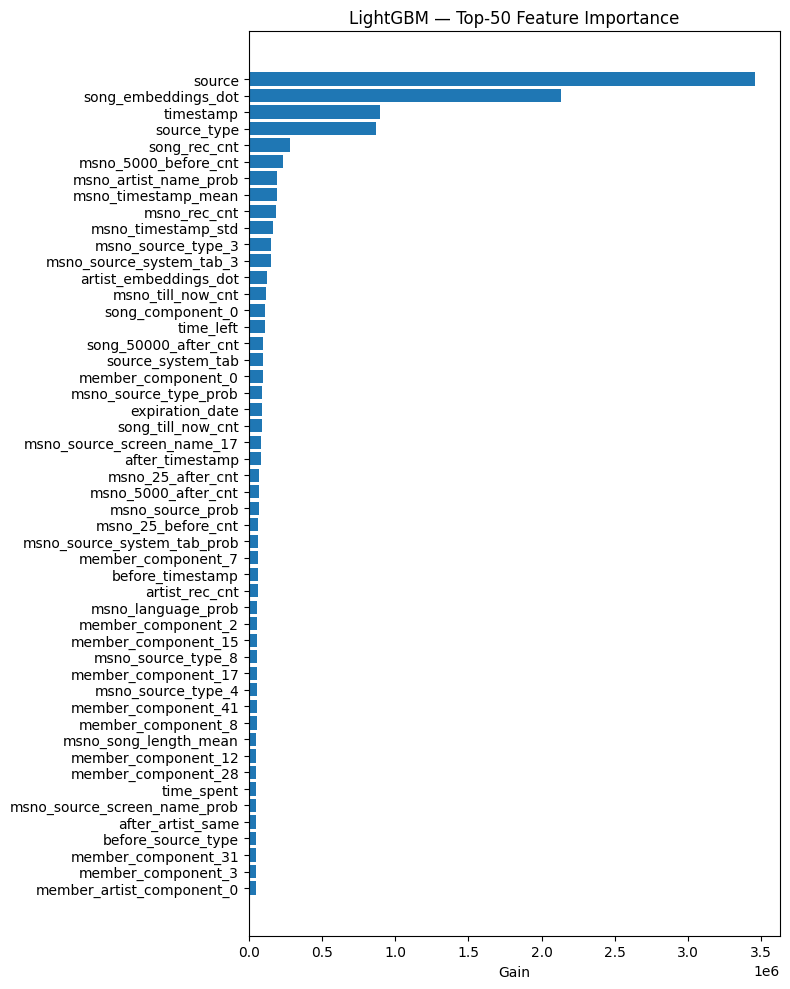

In [ ]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt

# загрузка модели
booster = lgb.Booster(model_file='lgb_model.txt')

# таблица важностей
imp = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance': booster.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(50)

# столбчатая диаграмма
plt.figure(figsize=(8, 10))
plt.barh(imp['feature'][::-1], imp['importance'][::-1])
plt.xlabel('Gain')
plt.title('LightGBM — Top-50 Feature Importance')
plt.tight_layout()
plt.savefig('lgb_feature_top50.png', dpi=300)
print("График сохранён в lgb_feature_top50.png")

In [ ]:
import joblib

# Загрузка модели
model = joblib.load('meta_logreg.pkl')

# 1. Тип модели
print(f"🔍 Model type: {type(model)}\n")

# 2. Архитектура или параметры модели
print("🧠 Model details / parameters:\n")
print(model)

# 3. (опционально) Для логистической регрессии можно вывести веса
if hasattr(model, 'coef_'):
    print("\n📊 Coefficients (weights):")
    print(model.coef_)
if hasattr(model, 'intercept_'):
    print("\n⚖️ Intercept:")
    print(model.intercept_)

🔍 Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>

🧠 Model details / parameters:

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

📊 Coefficients (weights):
[[3.27704595 0.19627554 2.24479043]]

⚖️ Intercept:
[-2.96570379]
